In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from simpletransformers.classification import ClassificationModel
import torch
from transformers import logging
import re

In [2]:
use_cuda = torch.cuda.is_available()
print(f"GPU available: {use_cuda}")

GPU available: False


In [3]:
def parse_custom_format(file_path):
    """
    Parse data in format:
    sentiment statement
    neutral Text...
    negative Text...
    positive Text...
    """
    try:
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
        print("Data loaded as standard CSV")
        return df
    except:
        print("Attempting to parse custom format...")
        
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        lines = file.readlines()
    
    sentiment = []
    statement = []
    
    for line in lines:
        if line.strip() == '' or line.startswith('sentiment statement'):
            continue
            
        match = re.match(r'(positive|negative|neutral)\s+(.*)', line.strip())
        if match:
            sentiment.append(match.group(1))
            statement.append(match.group(2))
    
    df = pd.DataFrame({
        'sentiment': sentiment,
        'statement': statement
    })
    
    print(f"Custom format parsed: {len(df)} entries found")
    return df

In [4]:
print("Loading dataset...")

df = pd.read_csv("Data.csv", encoding='ISO-8859-1')

print(f"Initial dataset shape: {df.shape}")
df.drop_duplicates(subset=['statement'], keep='first', inplace=True)
print(f"Shape after removing duplicates: {df.shape}")

print("\nSample data:")
print(df.head(5))

Loading dataset...
Initial dataset shape: (4846, 2)
Shape after removing duplicates: (4838, 2)

Sample data:
  sentiment                                          statement
0   neutral  Technopolis plans to develop in stages an area...
1  negative  The international electronic industry company ...
2  positive  With the new production plant the company woul...
3  positive  According to the company 's updated strategy f...
4  positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [5]:
sentiment_counts = df['sentiment'].value_counts()
print("\nClass distribution:")
print(sentiment_counts)


Class distribution:
sentiment
neutral     2871
positive    1362
negative     605
Name: count, dtype: int64


Text(0, 0.5, 'Count')

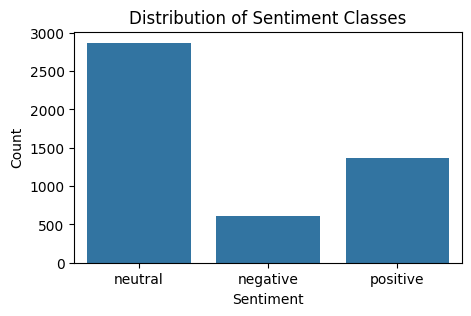

In [8]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')

In [9]:
df['text_length'] = df['statement'].apply(len)
print(f"\nAverage text length: {df['text_length'].mean():.1f} characters")
print(f"Min text length: {df['text_length'].min()} characters")
print(f"Max text length: {df['text_length'].max()} characters")


Average text length: 128.0 characters
Min text length: 9 characters
Max text length: 315 characters


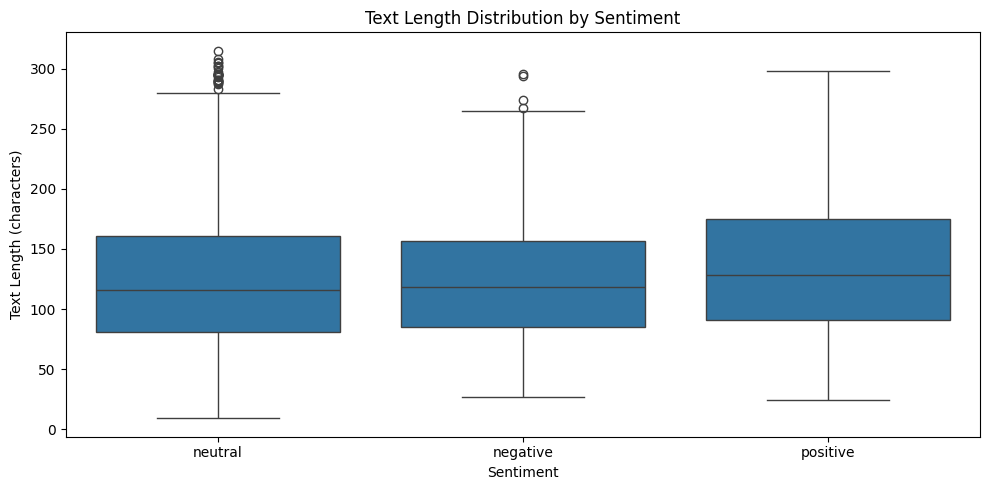

In [10]:
plt.figure(figsize=(10,5))
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length (characters)')
plt.tight_layout()
plt.show()

In [11]:
def make_label(sentiment):
    mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
    return mapping[sentiment]

In [12]:
df['label'] = df['sentiment'].apply(make_label)

In [13]:
def get_sentiment_label(label):
    mapping = {0: 'positive', 1: 'negative', 2: 'neutral'}
    return mapping[label]

In [14]:
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"\nTraining set size: {train_df.shape[0]}")
print(f"Evaluation set size: {eval_df.shape[0]}")


Training set size: 3870
Evaluation set size: 968


In [15]:
train_data = pd.DataFrame({
    'text': train_df['statement'].replace(r'\n', ' ', regex=True),
    'label': train_df['label']
})

In [17]:
model_args = {
    'num_train_epochs': 2,            # Reduced from 3 to speed up training
    'learning_rate': 3e-5,            # Slightly increased for faster convergence
    'max_seq_length': 128,            # Reduced from 256 to lower memory usage
    'train_batch_size': 8,            # Reduced from 16 to prevent memory issues
    'eval_batch_size': 16,            # Reduced from 32 to prevent memory issues
    'overwrite_output_dir': True,
    'reprocess_input_data': True,
    'save_eval_checkpoints': False,
    'save_model_every_epoch': False,
    'evaluate_during_training': True,
    'evaluate_during_training_steps': 2000,  # Added to evaluate less frequently
    'evaluate_during_training_verbose': False,  # Changed to reduce output
    'output_dir': 'outputs/',
    'best_model_dir': 'outputs/best_model/',
    'fp16': False,                    # Keep as False for Mac compatibility
    'manual_seed': 42,
    'no_cache': True,                 # Added to reduce disk I/O
    'use_multiprocessing': False,     # Added to prevent Mac overheating
    'silent': True                    # Added to reduce console output
}

In [19]:
print("\nInitializing BERT model...")
model = ClassificationModel(
    'bert', 
    'bert-base-cased', 
    num_labels=3, 
    args=model_args,
    use_cuda=use_cuda
)


Initializing BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
print("\nTraining the model...")
model.train_model(train_data, eval_df=eval_data)

(968,
 defaultdict(list,
             {'global_step': [484, 968],
              'train_loss': [0.39267444610595703, 0.12846241891384125],
              'mcc': [0.7077248951873656, 0.7459090879469803],
              'eval_loss': [0.4234566397842814, 0.48885184476060456]}))

In [21]:
print("\nEvaluating the model on test data...")
result, model_outputs, wrong_predictions = model.eval_model(eval_data)

In [22]:
predictions = np.argmax(model_outputs, axis=1)
true_labels = eval_data['label'].values

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['positive', 'negative', 'neutral']))


Classification Report:
              precision    recall  f1-score   support

    positive       0.85      0.75      0.80       273
    negative       0.81      0.85      0.83       121
     neutral       0.87      0.91      0.89       574

    accuracy                           0.86       968
   macro avg       0.85      0.84      0.84       968
weighted avg       0.86      0.86      0.86       968



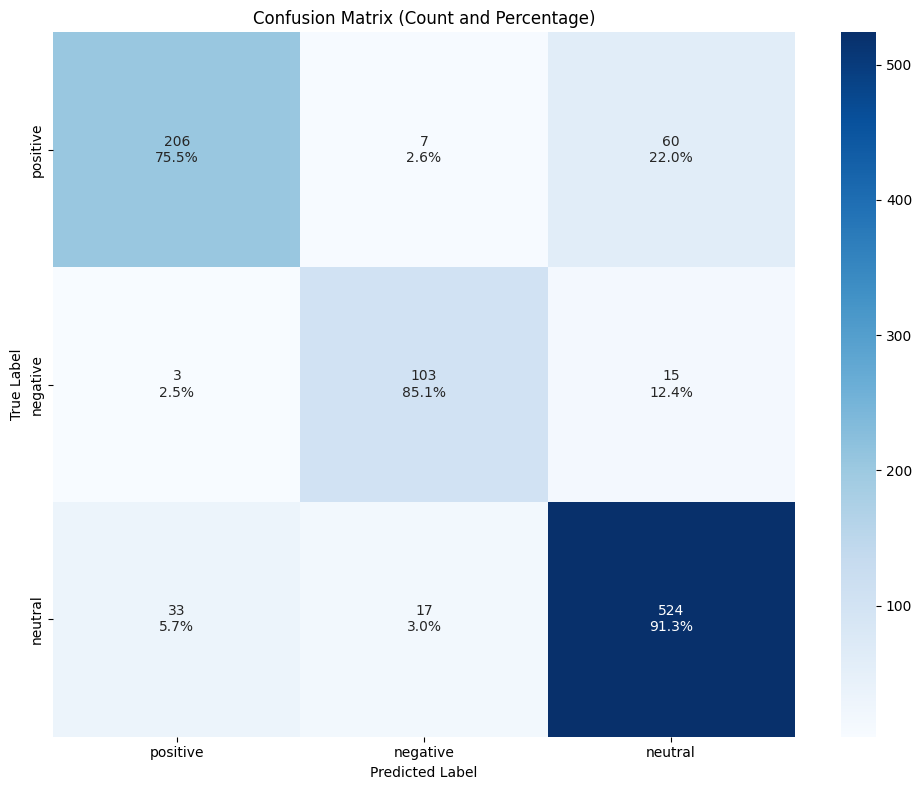

In [23]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap with both count and percentage
sns.heatmap(
    cm, 
    annot=np.asarray([
        [f"{val}\n{p:.1%}" for val, p in zip(row, row_norm)] 
        for row, row_norm in zip(cm, cm_norm)
    ]),
    fmt='', 
    cmap='Blues', 
    xticklabels=['positive', 'negative', 'neutral'],
    yticklabels=['positive', 'negative', 'neutral']
)
plt.title('Confusion Matrix (Count and Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [28]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [29]:
def predict_sentiment(text, return_confidence=False, return_explanation=False):
    result, raw_outputs = model.predict([text])
    predicted_label = int(result[0])
    sentiment = get_sentiment_label(predicted_label)
    
    # Calculate confidence using softmax
    probabilities = torch.nn.functional.softmax(torch.tensor(raw_outputs[0]), dim=0).numpy()
    confidence = float(probabilities[predicted_label])
    
    if not (return_confidence or return_explanation):
        return sentiment
    
    # Prepare additional information
    info = {'confidence': confidence}
    
    if return_explanation:
        # Generate explanation based on confidence levels
        all_probs = {get_sentiment_label(i): float(p) for i, p in enumerate(probabilities)}
        
        if confidence > 0.8:
            explanation = f"The model is very confident this is {sentiment} content."
        elif confidence > 0.6:
            explanation = f"The model is reasonably confident this is {sentiment} content."
        elif confidence > 0.4:
            explanation = "The model is somewhat uncertain about this prediction."
        else:
            # Find the second highest sentiment
            second_sentiment = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)[1][0]
            explanation = f"The model is uncertain between {sentiment} and {second_sentiment}."
            
        info['explanation'] = explanation
        info['all_probabilities'] = all_probs
    
    return sentiment, info

In [30]:
print("\n--- Example predictions ---")
test_examples = [
    "Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications, the statement said.",
    "The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility; contrary to earlier layoffs the company contracted the ranks of its office workers, the daily Postimees reported.",
    "With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability.",
    "The company's stock price fell by 15% after reporting lower than expected earnings.",
    "Revenue growth exceeded analyst expectations, with a 12% increase year-over-year."
]

print("\nPredicting examples:")
for i, example in enumerate(test_examples, 1):
    sentiment, info = predict_sentiment(example, return_confidence=True, return_explanation=True)
    print(f"\nExample {i}:")
    print(f"Text: {example[:80]}...")
    print(f"Sentiment: {sentiment.upper()} (confidence: {info['confidence']:.2%})")
    print(f"Explanation: {info['explanation']}")



--- Example predictions ---

Predicting examples:

Example 1:
Text: Technopolis plans to develop in stages an area of no less than 100,000 square me...
Sentiment: NEUTRAL (confidence: 99.74%)
Explanation: The model is very confident this is neutral content.

Example 2:
Text: The international electronic industry company Elcoteq has laid off tens of emplo...
Sentiment: NEGATIVE (confidence: 98.94%)
Explanation: The model is very confident this is negative content.

Example 3:
Text: With the new production plant the company would increase its capacity to meet th...
Sentiment: POSITIVE (confidence: 99.53%)
Explanation: The model is very confident this is positive content.

Example 4:
Text: The company's stock price fell by 15% after reporting lower than expected earnin...
Sentiment: NEGATIVE (confidence: 99.03%)
Explanation: The model is very confident this is negative content.

Example 5:
Text: Revenue growth exceeded analyst expectations, with a 12% increase year-over-year...
Sentiment